In [66]:
from rdflib import Graph, Namespace, Literal, BNode, URIRef
import os
import getpass
from langchain.document_loaders import TextLoader
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.schema import Document
from sklearn.cluster import KMeans
import json

In [58]:
os.environ['OPENAI_API_KEY'] = getpass.getpass('OpenAI API Key:')

In [30]:
# Load the graph
g = Graph()
g.parse("data/dunbar/bacnet.ttl", format="turtle")

<Graph identifier=N7f354840f7bc4cf58b9d6b6afbbe75b0 (<class 'rdflib.graph.Graph'>)>

In [33]:
# Load jsonld file
data = json.load(open("data/dunbar/bacnet.jsonld"))

In [89]:
# Create the documents to load into the vector store
documents = []

# Loop through the jsonld file and create a document for each
for i in range(0, len(data)):
    # Check if its a bacnet device or point
    type = data[i]["@type"][0]
    if type == "http://data.ashrae.org/bacnet/2016#bacnet_Point":
        device_name = data[i]['http://data.ashrae.org/bacnet/2016#device_name'][0]['@value']
        point_name = data[i]['http://data.ashrae.org/bacnet/2016#object_name'][0]['@value']
        present_value = data[i]['http://data.ashrae.org/bacnet/2016#present_value'][0]['@value']
        unit = data[i]['http://data.ashrae.org/bacnet/2016#object_units'][0]['@value']

        # Create the document
        content = point_name + " " + present_value + " " + unit
        # documents.append(Document(page_content=content, metadata={"type": "bacnet_point", }))
    elif type == "http://data.ashrae.org/bacnet/2016#bacnet_Device":
        device_name = data[i]['http://data.ashrae.org/bacnet/2016#device_name'][0]['@value']

        # Create the document
        content = device_name
        documents.append(Document(page_content=content, metadata={"type": "bacnet_device"}))

In [90]:
# Load the documents into the vector store
db = Chroma.from_documents(documents, OpenAIEmbeddings())

In [91]:
vectorstore_data = db.get(include=["embeddings", "metadatas"])
embs = vectorstore_data["embeddings"]

/Users/anthonydemattos/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Inertia for 1 clusters: 2893.1399862388344


/Users/anthonydemattos/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Inertia for 2 clusters: 2651.114409622811


/Users/anthonydemattos/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Inertia for 3 clusters: 2454.548942029972


/Users/anthonydemattos/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Inertia for 4 clusters: 2330.7494608170928


/Users/anthonydemattos/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Inertia for 5 clusters: 2222.3144045857125


/Users/anthonydemattos/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Inertia for 6 clusters: 2134.8048728713006


/Users/anthonydemattos/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Inertia for 7 clusters: 2048.4030341938255


/Users/anthonydemattos/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Inertia for 8 clusters: 1968.0017328934941


/Users/anthonydemattos/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Inertia for 9 clusters: 1890.3655090878422


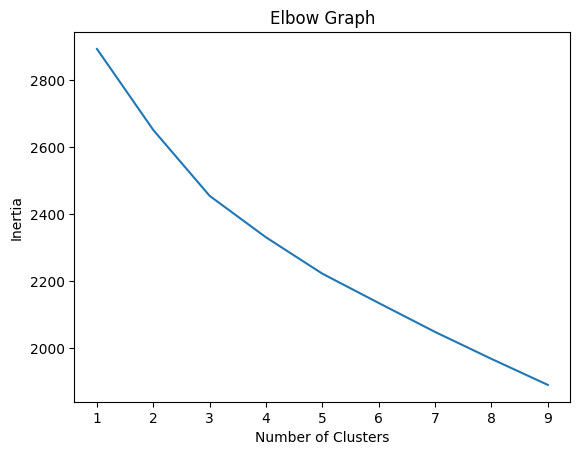

In [92]:
# Use the elbow method to find the optimal number of clusters
import matplotlib.pyplot as plt
import numpy as np

# Create the kmeans object
kmeans = KMeans()

# Create the list of inertias
inertias = []

# Loop through the number of clusters and calculate the inertia
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(embs)
    inertias.append(kmeans.inertia_)
    print("Inertia for {} clusters: {}".format(i, kmeans.inertia_))

# Plot the elbow graph
plt.plot(range(1, 10), inertias)
plt.title("Elbow Graph")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

In [93]:
# Set the number of clusters from the elbow graph
num_clusters = 40

# Perform k-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
cluster_assignments = kmeans.fit_predict(embs)
cluster_assignments

/Users/anthonydemattos/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([34, 17, 22, ..., 25, 29, 25], dtype=int32)

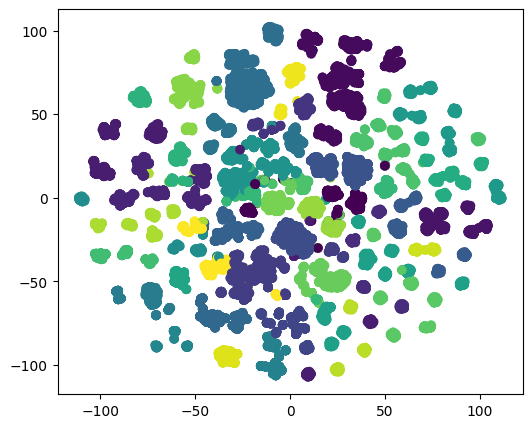

In [95]:
# Plot the clusters
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Convert list to numpy array
embs_array = np.array(embs)

tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(embs_array)

plt.figure(figsize=(6, 5))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_assignments)
plt.show()